# Bayesian Inference on Gaussian data

In this example, we will use the `racecar` library to infer the mean from two dimensional Gaussian data.

We will compare the results for sampling the posterior for a number of available algorithms.

First, we import our packages and create a dataset.

In [1]:
# Import our packages
import racecar as rc
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from functools import partial

print('This example was run with Racecar Version %s' % rc.__version__)

# Set the Seaborn defaults
sns.set()

# Set a seed for reproducibility
np.random.seed(314159)

This example was run with Racecar Version 0.0.9


We will draw $100$ datapoints from $\textrm{N}({\mu},I)$ where $x\in\mathbb{R}^2$.

We encourage you to play around with a larger number of datapoints and a higher dimension, these are chosen for demonstration only.

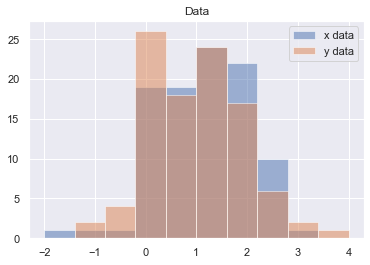

In [2]:
# Set the data mean
mu = 1.0

# Set the data dimension and number of data points
Ndim = 2
Ndata = 100

# Create the Gaussian data
D = mu + np.random.randn( Ndim, Ndata)

# Plot the data
plt.hist(D[0,:],np.linspace(mu-3,mu+3,11),alpha=0.5,label='x data')
plt.hist(D[1,:],np.linspace(mu-3,mu+3,11),alpha=0.5,label='y data')
plt.title('Data')
plt.legend()
plt.show()

We will sample the posterior distribution for the mean of this dataset, given as $x \sim \pi(x\,|\,D) \propto \exp(\sum_i \|x-D_i\|^2/2 )$ for $x\in\mathbb{R}^2$. The sampler object takes a function that gives some information about this posterior distribution up to a constant multiple, so we do not need to worry about the normalization constant.

We first define the posterior function `llh` that will return the log posterior, the total gradient, and the gradient of the posterior with respect to each data point (_i.e._ an array of $\nabla_x \log(\pi(x\,|\,D_i))$ values). It also accepts a list of indexes for which datapoints to use.

The `partial` command then allows us to set the data to be the total dataset `D` and to use all `Ndata` indexes.

In [3]:
def llh(x , data, idxs):
    
    data_batch = data[:, idxs]
    
    sf = data.shape[1] / len(idxs)
    
    V = -np.sum( (x-data_batch)**2 )/2
    grad_data = -(x-data_batch)
    grad = np.sum(grad_data,1,keepdims=True) * sf 
    
    return {
        'llh': V,
        'grad' : grad,
        'grad_data': grad_data
    }
    
# Use "partial" to create a function f(x) with the other keywords fixed
f = partial(llh, data=D, idxs=np.arange(Ndata))

We can set the initial condition for the sampler.

In [4]:
# Set the initial condition
initial_condition = mu*np.ones( [Ndim , 1] )

We will compare the output samples for six algorithms:

- Racecar
- SGHMC
- SGLD
- BAOAB
- Hybrid Monte Carlo (HMC) 
- Leimkuhler-Matthews (LM)

Check the [Algorithms](https://racecar.readthedocs.io/en/latest/algorithms.html) page in the docs for more details on each one.

We will plot the sampled mean and variance, and compare it to the true mean and variance from the posterior distribution. We use a time discretization step to give roughly equal sampling efficiency to all of the schemes. All step sizes are fixed during the course of the run.

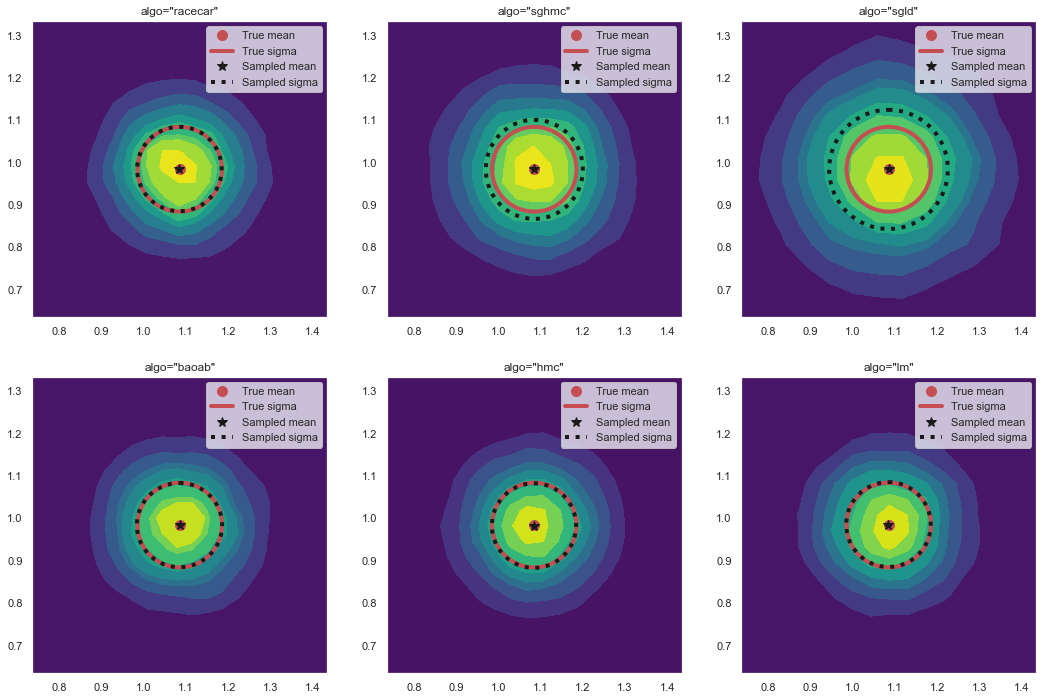

In [5]:
# Compute the exact distribution from the data. 
exact_mu = D.mean(1, keepdims=True)
thetas = np.linspace(0,2*np.pi,100) 
sdv = 1/np.sqrt(Ndata)
cx = exact_mu + [sdv*np.sin(thetas), sdv*np.cos(thetas)]

# Create the Figure object
fig = plt.figure(figsize=[18,12]) 

# Compare results from six algorithms.
# We do not compare against Random Walk Metropolis
algos = ['racecar','sghmc','sgld','baoab','hmc','lm']

# The timestep to use for each algorithm
hvals = [0.1,0.1,0.01,0.1,0.1,0.01 ]

# Sample Nsteps-many points to reduce sample error
Nsteps = 100000

# Iterate over the algorithms and plot the resulting posterior
for ii, (a,h) in enumerate(zip(algos, hvals)):
    
    # Create the Sampler object
    S = rc.sampler(initial_condition, h, f, algo=a)
    
    # Sample 1000 initial steps to decorrelate from the initial condition
    S.sample(1000, output=[])
    
    # Sample a longer trajectory to generate statistics
    # Thin the trajectory, keeping one in 10 points
    Q = S.sample(Nsteps, output=['pos'], thin=10) 
    
    # Compute the mean and variance of the sampled distribution for comparison
    mymu = Q.mean(0, keepdims=True).T
    mycx = mymu + [((Q.std(0)[0]))*np.sin(thetas), ((Q.std(0)[1]))*np.cos(thetas)]
    
    # Plot the results
    ax = fig.add_subplot(2,3,ii+1)
    gph = sns.kdeplot(x=Q[:,0],y=Q[:,1], gridsize=25, levels=10 , thresh=0, shade=True, cmap='viridis',ax=ax)
    plt.plot( [exact_mu[0] ],[exact_mu[1] ],'ro',markersize=10, label="True mean")
    plt.plot( cx[0,:],cx[1,:],'-r',linewidth=4,label="True sigma")  
    plt.plot( [ mymu[0]],[ mymu[1]],'k*',markersize=10,label="Sampled mean")
    plt.plot( mycx[0,:],mycx[1,:],':k',linewidth=4,label="Sampled sigma")
    plt.legend()
    
    gph.set(ylim=[exact_mu[1]-3.5*sdv,exact_mu[1]+3.5*sdv])
    gph.set(xlim=[exact_mu[0]-3.5*sdv,exact_mu[0]+3.5*sdv])
    gph.set(title='algo="%s"' % a) 

We can see that the Racecar, BAOAB, HMC and LM schemes all give very accurate results, while the SGHMC and SGLD schemes include a bias in their sampled variance.

We now consider sampling the posterior using a stochastic gradient term.

### Using a stochastic gradient

The BAOAB, HMC and LM algorithms are not recommended when using a stochastic gradient, so we will compare the output of the Racecar, SGHMC and SGLD algorithms.

We will run the same code as before, but now only use half the total data for each evaluation of `llh`. We randomly choose indexes of the data without replacement, and the `llh` function rescales the gradient to ensure the mean of the stochastic gradient is correct.

Note that the target posterior does not change, but each gradient (or _force_) evaluation requires half the computational effort from before (however in practice as our data is so small we do not see a factor 2 speed up in wall time in this example thanks to _numpy_'s vectorization). We can choose the batch size to be much smaller if we wish, but some algorithms require re-parameterization.

In [6]:
# Define the batch size
Nbatch = Ndata//2

# Choose Nbatch indexes of the data, without replacement
def llh_noisy(x , batchsize ): 
    return llh(x, data=D , idxs=np.random.choice(Ndata , batchsize, replace=False)) 

f_stoch = partial(llh_noisy, batchsize=Nbatch)

We rerun the same code as before, but now with the stochastic gradient using subsampled gradient terms.

The Racecar algorithm uses the `grad_data` output (_if given_) to find the directions of the gradient noise, and learns the damping required to remove it in an on-line fashion.

The SGLD algorithm is much simpler, it does not reduce the additional bias from the gradient noise via any added mechanism.

The SGHMC algorithm uses a user-provided estimate of the gradient noise's covariance. It also requires a damping term to correctly balance the stochastic gradient - smaller batchsizes require either increasing `g` or reducing the stepsize. The package will automatically increase the damping if needed, unless told not to by setting `auto_friction` to `False`.

In [7]:
# Calculated as the covariance of a partial sum
def SGHMC_noise_estimate(B,grad_data):
    
    Bfac = (Ndata * (Ndata - Nbatch) / Nbatch)
    new_B = np.cov( grad_data ) * Bfac
    
    return new_B

# Compare the truth versus the estimated:
#
# Compute the covariance of 10000 stochastic gradient evals
grad_covariance = np.cov( np.hstack([f_stoch(initial_condition)['grad'] for repeat in range(10000)] )) 

# Compute the mean of 10000 noise estimates. Note that grad_data is itself a stochastic estimation!
estimated_grad_covariance = [SGHMC_noise_estimate( B=None, grad_data=f_stoch(initial_condition)['grad_data'] ) 
                                                                  for repeat in range(10000)]

print('True covariance matrix of the stochastic grad:')
print( grad_covariance  )
print('\nMean of the "SGHMC noise estimate" function:')
print( np.array( estimated_grad_covariance).mean(0) )

True covariance matrix of the stochastic grad: 
[[99.34381703 13.44019234]
 [13.44019234 84.7524144 ]]

Mean of the "SGHMC noise estimate" function 
[[100.50293215  13.27085608]
 [ 13.27085608  85.81803928]]


The two outputs should be approximately commensurate. This estimate can be further improved by using _e.g._ averaging techniques, the Hessian, or the Fisher Information, but this is beyond the scope of this tutorial.

We can now run the experiment below, similarly comparing the sampled variance of the posterior distributions.

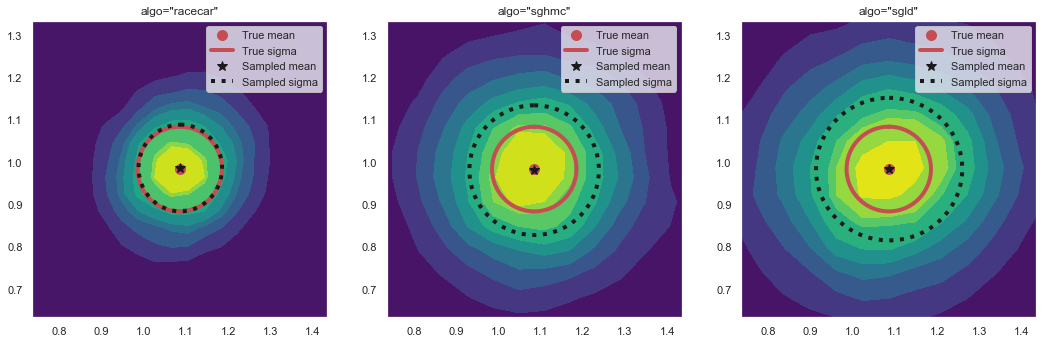

In [8]:
# Create the Figure object
fig = plt.figure(figsize=[18,12]) 

# Compare results from six algorithms.
# We do not compare against Random Walk Metropolis
algos = ['racecar','sghmc','sgld']

# The timestep to use for each algorithm
hvals = [0.1,0.1,0.01]

# Run a longer trajectory of Nsteps
Nsteps = 100000

# Parameters 
params = [ {},
         {"grad_cov":SGHMC_noise_estimate},
         {}, 
         ]

# Iterate over the algorithms and plot the resulting posterior
for ii, (a,h,p) in enumerate(zip(algos, hvals,params)): 
    
    # Create the Sampler object
    S = rc.sampler(initial_condition, h, f_stoch, algo=a, params=p)
    
    # Sample 1000 initial steps to decorrelate from the initial condition
    S.sample(1000, output=[])
    
    # Sample a longer trajectory to generate statistics
    # Thin the trajectory, keeping one in 10 points
    Q = S.sample(Nsteps, output=['pos'], thin=10)  
    
    # Compute the mean and variance of the sampled distribution for comparison
    mymu = Q.mean(0, keepdims=True).T
    mycx = mymu + [((Q.std(0)[0]))*np.sin(thetas), ((Q.std(0)[1]))*np.cos(thetas)]
    
    # Plot the results
    ax = fig.add_subplot(2,3,ii+1)
    gph = sns.kdeplot(x=Q[:,0],y=Q[:,1], gridsize=25, levels=10 , thresh=0, shade=True, cmap='viridis',ax=ax)
    plt.plot( [exact_mu[0] ],[exact_mu[1] ],'ro',markersize=10, label="True mean")
    plt.plot( cx[0,:],cx[1,:],'-r',linewidth=4,label="True sigma")  
    plt.plot( [ mymu[0]],[ mymu[1]],'k*',markersize=10,label="Sampled mean")
    plt.plot( mycx[0,:],mycx[1,:],':k',linewidth=4,label="Sampled sigma")
    plt.legend()
    
    gph.set(ylim=[exact_mu[1]-3.5*sdv,exact_mu[1]+3.5*sdv])
    gph.set(xlim=[exact_mu[0]-3.5*sdv,exact_mu[0]+3.5*sdv])
    gph.set(title='algo="%s"' % a) 

The Racecar algorithm does extremely well, with virtually no visible bias in the sampled distribution. The SGHMC scheme and SGLD scheme give a modest increase in the observed bias compared to when using the original gradient routine.